<a href="https://colab.research.google.com/github/sanchitgoel7/News-headline-LDA/blob/main/news__headline_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import json 

data = []

with open('/content/drive/MyDrive/Data/News_Category_Dataset_v2.json') as files:
  for file in files:
    data.append(json.loads(file))

df = pd.DataFrame(data)    

df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   authors            200853 non-null  object
 3   link               200853 non-null  object
 4   short_description  200853 non-null  object
 5   date               200853 non-null  object
dtypes: object(6)
memory usage: 9.2+ MB


In [ ]:
df = df.groupby('category', group_keys=False).apply(lambda x: x.sample(1000))

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41000 entries, 96378 to 94183
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           41000 non-null  object
 1   headline           41000 non-null  object
 2   authors            41000 non-null  object
 3   link               41000 non-null  object
 4   short_description  41000 non-null  object
 5   date               41000 non-null  object
dtypes: object(6)
memory usage: 2.2+ MB


In [ ]:
headlines = df['headline']

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    !python -m spacy download en_core_web_lg
    !pip install pyldavis
    !pip install gensim
    !pip install chart_studio

In [ ]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
headlines.head(20)

96378     Love, Multiplied: Recent Screening at Yangon P...
124977                      Aisle View: Kiss of the Vampire
119592    Universal Humanism or Identity Art? Which Work...
124002                                          4000 Blocks
95479     Night at the Museum: The Guggenheim Museum's Y...
80356               Aisle View: Laughter From the Panhandle
87803                        Aisle View: Gloria's Wild Ride
98993         Nude Photography, By Women Of Women For Women
89972     This Love Story Will Make Every Scrabble Nerd'...
62400                The Revolution Will Not Be Compromised
117129            Surreal Portraits Of 'Face-Peeled' People
92635     First Nighter: Anne Hathaway in "Grounded," Ir...
94906                                   Explosive Illusions
94009     Is Borecore The New Normcore, Or Just The Way ...
87763        From Walls to Wheels: Driving Art in High Gear
116527    Artist Sends 99 Sad Critters Down China's 'Dea...
121757        Postscript: Opera Criticis

In [ ]:
headlines = headlines.sample(n = 25000)

In [ ]:
head_lengths = [len(headline) for headline in headlines]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


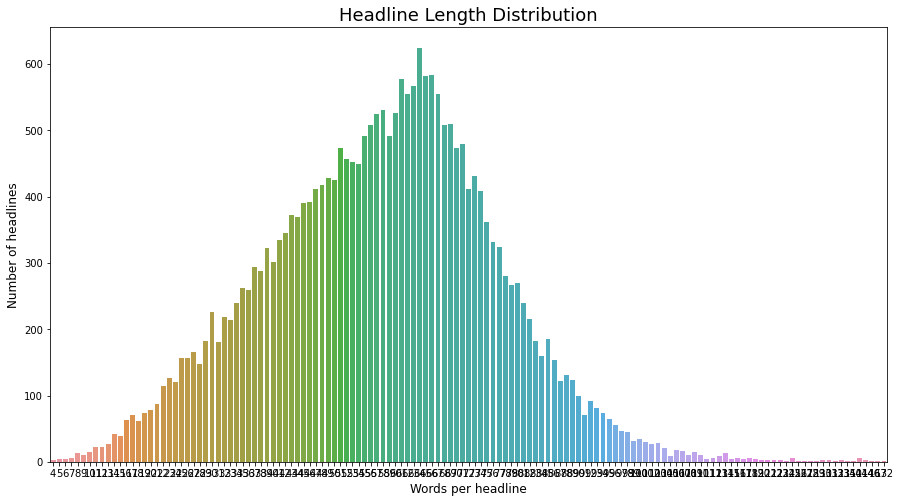

In [ ]:
plt.figure(figsize = (15,8))
sns.countplot(head_lengths)
plt.title('Headline Length Distribution', fontsize = 18)
plt.xlabel('Words per headline', fontsize = 12)
plt.ylabel('Number of headlines', fontsize = 12)
plt.show()

In [ ]:
print(np.quantile(head_lengths,.05))
print(np.quantile(head_lengths,.95))

26.0
87.0


In [ ]:
headlines = headlines[headlines.apply(lambda x: len(x) >= 26 and len(x) <= 87)]

In [ ]:
df = pd.DataFrame()
df['headlines'] = headlines
df

,headlines
163995,Sex or Weight: Which Would You Rather Talk to ...
24563,What Is World Oceans Day Meant To Do?
135181,The Conscience of the King
26997,13 MLB Players Denounce Repression And Deaths ...
12391,Michigan Police Troll ‘Stranger Things’ Fans W...
...,...
139907,"The Global Search for Education: The 300,000 -..."
35780,New Presidental Era Stokes Gay Teen Fear
71990,Organic Gatorade Will Arrive In 2016 From Peps...
23915,How World Cities Moving Forward On Climate Cha...


In [ ]:
nlp = spacy.load('en_core_web_lg')


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['headlines'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

# View df
df

In [ ]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)

# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

In [ ]:
df.head(5)

,headlines,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text
163995,Sex or Weight: Which Would You Rather Talk to ...,"[sex, weight:, talk, kids, about?]",sex weight: talk kids about?,"[sex, weight, talk, kid]",sex weight talk kid
24563,What Is World Oceans Day Meant To Do?,"[world, oceans, day, meant, do?]",world oceans day meant do?,"[world, oceans, day, mean]",world oceans day mean
135181,The Conscience of the King,"[conscience, king]",conscience king,"[conscience, king]",conscience king
26997,13 MLB Players Denounce Repression And Deaths ...,"[13, mlb, players, denounce, repression, death...",13 mlb players denounce repression deaths nati...,"[13, mlb, player, denounce, repression, death,...",13 mlb player denounce repression death native...
12391,Michigan Police Troll ‘Stranger Things’ Fans W...,"[michigan, police, troll, ‘stranger, things’, ...",michigan police troll ‘stranger things’ fans j...,"[michigan, police, troll, strange, thing, fan,...",michigan police troll strange thing fan jail w...


In [ ]:
df.to_pickle('drive/MyDrive/Data/cleaned_headlines.pkl')

In [ ]:
df = pd.read_pickle('drive/MyDrive/Data/cleaned_headlines.pkl')

In [ ]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    tokens = re.sub('[^a-zA-Z ]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', tokens) # Remove punctuation

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(lambda x : tokenize(str(x)))

In [ ]:
df.head()

,headlines,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
163995,Sex or Weight: Which Would You Rather Talk to ...,"[sex, weight:, talk, kids, about?]",sex weight: talk kids about?,"[sex, weight, talk, kid]",sex weight talk kid,"[sex, weight, talk, kid]"
24563,What Is World Oceans Day Meant To Do?,"[world, oceans, day, meant, do?]",world oceans day meant do?,"[world, oceans, day, mean]",world oceans day mean,"[world, oceans, day, mean]"
135181,The Conscience of the King,"[conscience, king]",conscience king,"[conscience, king]",conscience king,"[conscience, king]"
26997,13 MLB Players Denounce Repression And Deaths ...,"[13, mlb, players, denounce, repression, death...",13 mlb players denounce repression deaths nati...,"[13, mlb, player, denounce, repression, death,...",13 mlb player denounce repression death native...,"[mlb, player, denounce, repression, death, nat..."
12391,Michigan Police Troll ‘Stranger Things’ Fans W...,"[michigan, police, troll, ‘stranger, things’, ...",michigan police troll ‘stranger things’ fans j...,"[michigan, police, troll, strange, thing, fan,...",michigan police troll strange thing fan jail w...,"[michigan, police, troll, strange, thing, fan,..."


In [ ]:
print(len(df))

22612


In [ ]:
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))

17670


In [ ]:
print(id2word.token2id)

{'kid': 0, 'sex': 1, 'talk': 2, 'weight': 3, 'day': 4, 'mean': 5, 'oceans': 6, 'world': 7, 'conscience': 8, 'king': 9, 'death': 10, 'denounce': 11, 'mlb': 12, 'native': 13, 'player': 14, 'repression': 15, 'venezuela': 16, 'fan': 17, 'jail': 18, 'michigan': 19, 'police': 20, 'strange': 21, 'thing': 22, 'troll': 23, 'tweet': 24, 'warning': 25, 'america': 26, 'claim': 27, 'county': 28, 'ohio': 29, 'opioid': 30, 'spiral': 31, 'spot': 32, 'black': 33, 'designer': 34, 'fashion': 35, 'finally': 36, 'get': 37, 'moment': 38, 'spotlight': 39, 'arrest': 40, 'deadly': 41, 'shooting': 42, 'spree': 43, 'suspect': 44, 'christians': 45, 'stand': 46, 'take': 47, 'white': 48, 'come': 49, 'paws': 50, 'santa': 51, 'town': 52, 'asylum': 53, 'ballen': 54, 'bird': 55, 'inside': 56, 'roger': 57, 'step': 58, 'familiar': 59, 'forget': 60, 'hama': 61, 'tragedy': 62, 'professor': 63, 'target': 64, 'watchlist': 65, 'body': 66, 'food': 67, 'spicy': 68, 'fear': 69, 'heighten': 70, 'jeff': 71, 'journalist': 72, 'leak

In [ ]:
id2word.filter_extremes(no_below=2, no_above=0.5)
print(len(id2word))

9349


In [ ]:
print(id2word.token2id)

{'age': 0, 'disability': 1, 'know': 2, 'right': 3, 'alarm': 4, 'decide': 5, 'smart': 6, 'wake': 7, 'business': 8, 'chief': 9, 'communication': 10, 'officer': 11, 'simpson': 12, 'woman': 13, 'azalea': 14, 'cut': 15, 'gown': 16, 'iggy': 17, 'out': 18, 'perfectly': 19, 'place': 20, 'de': 21, 'dress': 22, 'la': 23, 'oscar': 24, 'photo': 25, 'renta': 26, 'spring': 27, 'wedding': 28, 'charm': 29, 'kardashian': 30, 'kim': 31, 'marriage': 32, 'time': 33, 'education': 34, 'public': 35, 'save': 36, 'thing': 37, 'us': 38, 'black': 39, 'burden': 40, 'space': 41, 'white': 42, 'bust': 43, 'dog': 44, 'firefighter': 45, 'icy': 46, 'lake': 47, 'trap': 48, 'watch': 49, 'christmas': 50, 'day': 51, 'hindu': 52, 'hundred': 53, 'priest': 54, 'vow': 55, 'bank': 56, 'excessive': 57, 'fire': 58, 'number': 59, 'report': 60, 'robber': 61, 'shot': 62, 'advocate': 63, 'card': 64, 'consumer': 65, 'fee': 66, 'overdraft': 67, 'prepaid': 68, 'sneak': 69, 'eat': 70, 'food': 71, 'night': 72, 'sleep': 73, 'well': 74, 'ev

In [ ]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

In [ ]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic    

In [ ]:
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df['lemma_tokens'],
                                                        start=2, limit=80, step=2)

In [ ]:
limit=80; start=2; step=2;
x_topic = range(start, limit, step)

topic_ts = {'coherence_value': coherence_values_topic,
            'number_of_topics': x_topic}

topic_chart = pd.DataFrame(data=topic_ts)

topic_fig = px.line(topic_chart, x="number_of_topics", y="coherence_value")
topic_fig.show()

In [ ]:
import pickle
with open('drive/MyDrive/Data/headline_plot_2.pickle', 'wb') as f: # should be 'wb' rather than 'w'
    pickle.dump(topic_fig, f) 

In [ ]:
#topics = 48
model_1 = model_list_topic[23]

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_1, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.138704  0.021839       1        1  2.642514
30     0.043529 -0.020410       2        1  2.453808
40     0.040648 -0.015166       3        1  2.414760
45     0.025114 -0.019482       4        1  2.371583
16     0.027392 -0.002280       5        1  2.353817
47     0.046794 -0.138342       6        1  2.306214
43    -0.254556 -0.061228       7        1  2.261237
14    -0.125869 -0.059212       8        1  2.254249
23    -0.023419  0.017719       9        1  2.224106
46     0.016792 -0.075616      10        1  2.209145
6     -0.016918 -0.082477      11        1  2.202516
3      0.000363  0.002169      12        1  2.190677
0     -0.037883  0.021049      13        1  2.184399
12    -0.122870 -0.007749      14        1  2.174727
39    -0.012530 -0.041987      15        1  2.147531
11    -0.085122  0.176501      16        1  2.146279
7      0.081073 -0.079933      17        1  2.144570
24    -0.020513  0.080692      18        1  2.142232
25     0.083958 -0.033426      19        1  2.127389
1     -0.034413 -0.068773      20        1  2.124330
36    -0.107393  0.015795      21        1  2.116631
19     0.105392  0.085367      22        1  2.102299
18     0.009849 -0.034830      23        1  2.082646
13     0.017834 -0.030040      24        1  2.031813
31     0.039903  0.177894      25        1  2.031364
28     0.027304 -0.038731      26        1  2.029321
29    -0.027987 -0.032932      27        1  2.027607
38     0.048729  0.060218      28        1  2.025447
4     -0.013911  0.071784      29        1  2.014084
9      0.008758  0.107131      30        1  2.009304
5      0.039058  0.020340      31        1  2.006983
2     -0.037936  0.116253      32        1  2.004771
44    -0.003020 -0.063805      33        1  2.003425
35     0.020453  0.029650      34        1  1.964499
21    -0.039386 -0.137077      35        1  1.964353
27     0.036740  0.060029      36        1  1.963011
22     0.060015  0.040060      37        1  1.957383
32     0.014254 -0.041847      38        1  1.934502
10     0.034588  0.022848      39        1  1.931211
37     0.076984  0.019220      40        1  1.927943
42     0.065455 -0.002801      41        1  1.925809
17    -0.110063  0.081028      42        1  1.916249
33     0.009842 -0.048787      43        1  1.914682
41     0.062774 -0.034897      44        1  1.898603
26    -0.014993 -0.026098      45        1  1.855923
15     0.102803  0.014221      46        1  1.852517
34     0.081276 -0.042786      47        1  1.809573
20    -0.000187 -0.001094      48        1  1.621962, topic_info=        Term        Freq       Total Category  logprob  loglift
523   school  332.000000  332.000000  Default  30.0000  30.0000
117    trump  755.000000  755.000000  Default  29.0000  29.0000
511     love  353.000000  353.000000  Default  28.0000  28.0000
4        day  585.000000  585.000000  Default  27.0000  27.0000
223     year  537.000000  537.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1449   stick   13.993229   37.145563  Topic48  -5.0165   3.1453
204      say   20.399624  473.309088  Topic48  -4.6396   0.9773
3028   dozen   13.365052   42.412648  Topic48  -5.0624   2.9667
140     work   13.447109  197.774375  Topic48  -5.0563   1.4332
1248     eye   12.168555   61.833780  Topic48  -5.1562   2.4959

[2858 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2841     27  0.907770     ability
1399      5  0.051194      abroad
1399     31  0.870305      abroad
2224     45  0.906531  abstinence
5738     45  0.908077      absurd
...     ...       ...         ...
4801     47  0.925751        zara
3785     31  0.946102       zebra
8901      9  0.907656         zig
6235     43  0.947802       zinke
943      48  0.934057  zuckerberg

[9972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts

In [ ]:
#topics = 32
model_2 = model_list_topic[15]
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_2, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
31     0.219999  0.043120       1        1  3.531840
30     0.177572 -0.054560       2        1  3.451070
18     0.070019  0.038276       3        1  3.396182
23     0.027556 -0.044122       4        1  3.365051
10    -0.171813  0.034539       5        1  3.347309
0     -0.049374  0.057040       6        1  3.330913
3     -0.077628 -0.036915       7        1  3.312511
5     -0.043193  0.105582       8        1  3.268788
29    -0.081101  0.024511       9        1  3.236154
16     0.015956 -0.079996      10        1  3.228828
1      0.033851 -0.063173      11        1  3.227403
17     0.086251 -0.003931      12        1  3.209947
9     -0.058505  0.130020      13        1  3.190427
21    -0.023880 -0.130896      14        1  3.187402
14    -0.063509 -0.011380      15        1  3.168748
20    -0.073240 -0.006290      16        1  3.134874
13    -0.027226 -0.095139      17        1  3.127258
28    -0.004582 -0.152624      18        1  3.099346
24    -0.045216 -0.005998      19        1  3.062956
6     -0.104302 -0.040245      20        1  3.056614
15     0.009723 -0.062966      21        1  3.055688
12     0.055798  0.107108      22        1  2.995187
8      0.003732  0.055753      23        1  2.993447
19    -0.008693 -0.026281      24        1  2.954855
2      0.068597  0.148373      25        1  2.945438
27     0.004276  0.102137      26        1  2.931841
4      0.042318  0.042383      27        1  2.921602
26    -0.016139 -0.059315      28        1  2.900607
7     -0.001057 -0.075276      29        1  2.886266
25    -0.054434  0.071688      30        1  2.857663
11     0.091010 -0.052372      31        1  2.843712
22    -0.002769  0.040946      32        1  2.780075, topic_info=        Term         Freq        Total Category  logprob  loglift
117    trump   732.000000   732.000000  Default  30.0000  30.0000
1517     bad   229.000000   229.000000  Default  29.0000  29.0000
238   donald   239.000000   239.000000  Default  28.0000  28.0000
118    photo  1122.000000  1122.000000  Default  27.0000  27.0000
511     love   361.000000   361.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
117    trump    29.867054   732.112256  Topic32  -4.7972   0.3835
7      world    24.772488   377.503071  Topic32  -4.9842   0.8588
356    young    19.506267   139.121165  Topic32  -5.2232   1.6181
257    video    21.150022   633.880114  Topic32  -5.1423   0.1825
1154     use    19.031186   120.530387  Topic32  -5.2478   1.7369

[2074 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2224     12  0.870870  abstinence
5738      1  0.843543      absurd
100       1  0.015997       abuse
100       4  0.031993       abuse
100       6  0.351927       abuse
...     ...       ...         ...
3785     17  0.885368       zebra
8901     22  0.931518         zig
6235     17  0.879600       zinke
943      23  0.050224  zuckerberg
943      28  0.904031  zuckerberg

[7612 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[32, 31, 19, 24, 11, 1, 4, 6, 30, 17, 2, 18, 10, 22, 15, 21, 14, 29, 25, 7, 16, 13, 9, 20, 3, 28, 5, 27, 8, 26, 12, 23])

In [ ]:
#topics = 16
model_2 = model_list_topic[7]
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_2, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.068004  0.046608       1        1  6.764047
11    -0.007811 -0.101338       2        1  6.712380
2      0.035652  0.116750       3        1  6.517639
3     -0.083893  0.091233       4        1  6.501799
0      0.046958 -0.031938       5        1  6.501037
13    -0.046434  0.181510       6        1  6.406267
4     -0.085268 -0.110933       7        1  6.380515
9     -0.080361  0.053767       8        1  6.277145
12    -0.006597 -0.001448       9        1  6.244954
1     -0.141114 -0.129857      10        1  6.212269
6      0.073957  0.030536      11        1  6.187363
15     0.213659 -0.010542      12        1  6.127904
8      0.048258 -0.125065      13        1  6.087364
14     0.096034 -0.038890      14        1  5.786693
7     -0.117371  0.037080      15        1  5.697824
10    -0.013671 -0.007474      16        1  5.594800, topic_info=         Term         Freq        Total Category  logprob  loglift
117     trump   771.000000   771.000000  Default  30.0000  30.0000
21      thing   376.000000   376.000000  Default  29.0000  29.0000
118     photo  1121.000000  1121.000000  Default  28.0000  28.0000
511      love   354.000000   354.000000  Default  27.0000  27.0000
238    donald   257.000000   257.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
118     photo    40.993559  1121.454357  Topic16  -5.1799  -0.4256
411  facebook    28.904432   132.107611  Topic16  -5.5293   1.3637
75     people    32.176252   307.490806  Topic16  -5.4221   0.6261
82      woman    31.128373   667.519367  Topic16  -5.4552  -0.1821
19     police    26.990125   180.293411  Topic16  -5.5978   0.9842

[1172 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2224      5  0.955272  abstinence
4941      5  0.190846   accessory
4941     11  0.801555   accessory
2451      1  0.114167       actor
2451      8  0.028542       actor
...     ...       ...         ...
4801      2  0.891679        zara
3785     14  0.910902       zebra
6235     15  0.896494       zinke
943       2  0.921832  zuckerberg
943      13  0.051213  zuckerberg

[4068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 12, 3, 4, 1, 14, 5, 10, 13, 2, 7, 16, 9, 15, 8, 11])

In [ ]:
#topics = 24
model_2 = model_list_topic[11]
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_2, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.082126 -0.142004       1        1  4.553134
14    -0.066335  0.087969       2        1  4.507920
4     -0.028349  0.003900       3        1  4.454036
9     -0.054743 -0.069481       4        1  4.382853
0     -0.151737  0.006141       5        1  4.307373
5      0.118296  0.065922       6        1  4.285234
8     -0.001828 -0.076464       7        1  4.265131
11    -0.001615 -0.092188       8        1  4.252445
18    -0.068977  0.027537       9        1  4.250654
3     -0.078442  0.061278      10        1  4.244986
6      0.155584  0.011864      11        1  4.205187
16     0.049021  0.001443      12        1  4.164339
23    -0.104777  0.084640      13        1  4.163316
21     0.135462 -0.120549      14        1  4.136076
19    -0.061024 -0.063266      15        1  4.100228
17    -0.017314  0.069547      16        1  4.061348
2      0.030021  0.108630      17        1  4.052913
7     -0.019933 -0.008294      18        1  4.027615
1     -0.033507 -0.076851      19        1  3.995593
20     0.049480  0.029413      20        1  3.991103
13     0.010844 -0.029231      21        1  3.947078
22     0.102434  0.162886      22        1  3.910900
12    -0.083189 -0.097008      23        1  3.887261
10     0.038502  0.054166      24        1  3.853274, topic_info=         Term        Freq       Total Category  logprob  loglift
125       new  925.000000  925.000000  Default  30.0000  30.0000
65       food  199.000000  199.000000  Default  29.0000  29.0000
21      thing  362.000000  362.000000  Default  28.0000  28.0000
1317   health  156.000000  156.000000  Default  27.0000  27.0000
301   divorce  336.000000  336.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
89       free   25.737657  124.567587  Topic24  -5.2724   1.6794
36        get   28.150160  244.497656  Topic24  -5.1828   1.0946
125       new   30.891554  925.797633  Topic24  -5.0899  -0.1439
334      life   25.638808  309.661945  Topic24  -5.2763   0.7649
133     paris   23.661469   84.265400  Topic24  -5.3565   1.9861

[1653 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2841     14  0.933360     ability
1399      5  0.931166      abroad
2224      5  0.903305  abstinence
5738     23  0.909888      absurd
6244     11  0.051826    academic
...     ...       ...         ...
3249      9  0.087184     youtube
3249     19  0.087184     youtube
4801     12  0.949304        zara
3785     19  0.931844       zebra
6235      2  0.956601       zinke

[5892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 15, 5, 10, 1, 6, 9, 12, 19, 4, 7, 17, 24, 22, 20, 18, 3, 8, 2, 21, 14, 23, 13, 11])

In [ ]:
model_32 = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=32,
                       random_state=1,
                       iterations = 70,
                       chunksize = 2000,
                       passes = 20
)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_32, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.050389 -0.136294       1        1  4.008005
30    -0.113907 -0.088387       2        1  3.766220
21    -0.130332  0.057990       3        1  3.765979
22     0.090553  0.073408       4        1  3.716737
10     0.019166 -0.114103       5        1  3.348179
7     -0.129483 -0.042106       6        1  3.337911
6     -0.163991  0.037580       7        1  3.313600
11     0.106764  0.077627       8        1  3.312779
4      0.129959  0.196905       9        1  3.303093
14    -0.032189 -0.049237      10        1  3.264699
16     0.084323 -0.117085      11        1  3.245920
15     0.006864 -0.036084      12        1  3.243446
23    -0.070402  0.188301      13        1  3.195816
18    -0.154891  0.003616      14        1  3.158861
12     0.077433 -0.101719      15        1  3.119738
8      0.038783 -0.039158      16        1  3.118769
1      0.029763 -0.028958      17        1  3.082348
27     0.024867 -0.020532      18        1  3.042229
5     -0.073094  0.012949      19        1  3.032467
31     0.010154  0.048900      20        1  3.004003
0      0.076911 -0.096784      21        1  2.966180
19    -0.138949  0.042328      22        1  2.957974
20    -0.069696  0.044218      23        1  2.891347
9     -0.073378 -0.034637      24        1  2.890787
2      0.128180  0.193467      25        1  2.867199
17    -0.074802 -0.048234      26        1  2.849820
29     0.112574 -0.116459      27        1  2.835497
26    -0.064427  0.046520      28        1  2.805600
24     0.063628  0.027693      29        1  2.781371
25     0.084968 -0.021076      30        1  2.633688
13     0.022916  0.030187      31        1  2.627761
28     0.131345  0.009166      32        1  2.511979, topic_info=          Term        Freq       Total Category  logprob  loglift
125        new  920.000000  920.000000  Default  30.0000  30.0000
117      trump  731.000000  731.000000  Default  29.0000  29.0000
4          day  541.000000  541.000000  Default  28.0000  28.0000
223       year  523.000000  523.000000  Default  27.0000  27.0000
104       find  369.000000  369.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
468   carolina   29.123108   33.360869  Topic32  -4.7210   3.5482
1662    review   34.169482   47.345694  Topic32  -4.5612   3.3580
1185   billion   31.099868   45.009591  Topic32  -4.6553   3.3144
2030  cocktail   25.698743   35.874510  Topic32  -4.8461   3.3505
75      people   23.945915  321.925816  Topic32  -4.9167   1.0856

[1263 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
100       6  0.127380    abuse
100      12  0.545913    abuse
100      16  0.127380    abuse
100      24  0.181971    abuse
2007     22  0.949623   accept
...     ...       ...      ...
3203     13  0.979512      yes
527      19  0.979235     yoga
160       5  0.993980     york
356      21  0.996030    young
3249      3  0.985115  youtube

[1671 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 31, 22, 23, 11, 8, 7, 12, 5, 15, 17, 16, 24, 19, 13, 9, 2, 28, 6, 32, 1, 20, 21, 10, 3, 18, 30, 27, 25, 26, 14, 29])

In [ ]:
model_24 = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=24,
                       random_state=1,
                       iterations = 70,
                       chunksize = 2000,
                       passes = 20
)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_24, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.086149 -0.049369       1        1  4.893843
6     -0.043351 -0.102010       2        1  4.781096
3     -0.081289 -0.117569       3        1  4.766763
7      0.060676 -0.008964       4        1  4.610497
10     0.048908 -0.206591       5        1  4.605835
14    -0.174508  0.013542       6        1  4.525532
2      0.181443  0.188135       7        1  4.493577
11     0.148523  0.114759       8        1  4.485254
0      0.050177 -0.200178       9        1  4.208060
22     0.125242  0.045340      10        1  4.190883
18    -0.152191 -0.008193      11        1  4.182531
20     0.089365  0.012084      12        1  4.111004
13    -0.077381  0.103095      13        1  4.037977
19    -0.141111  0.011946      14        1  3.985626
1      0.022609 -0.016843      15        1  3.980723
15    -0.069786  0.121583      16        1  3.936704
23    -0.089336  0.028294      17        1  3.922906
8     -0.048149 -0.043130      18        1  3.919096
17    -0.083915  0.025784      19        1  3.882662
9      0.157834 -0.019873      20        1  3.877473
21    -0.062230  0.112758      21        1  3.798284
5      0.036308  0.039701      22        1  3.647277
16    -0.112030  0.043019      23        1  3.599911
12     0.128043 -0.087320      24        1  3.556487, topic_info=        Term        Freq       Total Category  logprob  loglift
125      new  905.000000  905.000000  Default  30.0000  30.0000
117    trump  746.000000  746.000000  Default  29.0000  29.0000
87       way  458.000000  458.000000  Default  28.0000  28.0000
223     year  518.000000  518.000000  Default  27.0000  27.0000
21     thing  369.000000  369.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1331  public   47.234171   74.134084  Topic24  -4.5851   2.8856
193      ban   45.679256   76.999131  Topic24  -4.6186   2.8142
406      run   43.652530  125.248375  Topic24  -4.6640   2.2824
82     woman   56.122899  650.134565  Topic24  -4.4127   0.8868
493     john   33.293709   81.843035  Topic24  -4.9348   2.4370

[1040 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1029      4  0.983082   abandon
187      10  0.971120  abortion
100       7  0.223198     abuse
100      24  0.755438     abuse
2007     22  0.978014    accept
...     ...       ...       ...
2169      1  0.982101     yemen
527       8  0.967146      yoga
160       5  0.995368      york
356      11  0.993427     young
3249     17  0.983644   youtube

[1518 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 4, 8, 11, 15, 3, 12, 1, 23, 19, 21, 14, 20, 2, 16, 24, 9, 18, 10, 22, 6, 17, 13])

In [ ]:
model_32.save("lda_32.model")

In [ ]:
model_24.save("/content/drive/MyDrive/Data/lda_24.model")

In [ ]:
model_32.save("/content/drive/MyDrive/Data/lda_32.model")

In [ ]:
model_list_topic[15].save("/content/drive/MyDrive/Data/lda_32_1.model")
model_list_topic[11].save("/content/drive/MyDrive/Data/lda_24_1.model")

In [ ]:
hghhmodel_.get_term_topics('husband')

[]